In [1]:
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rizvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Custom Dataset

In [3]:
class BanglaDataset(Dataset):
    def __init__(self, df, max_seq_len=90):
        self.df = df
        self.nsamples = len(self.df)
        glove_data_file = r'E:\Bangla-Sentiment-Analysis\Word Embeddings\bn_glove.39M.300d.txt'  
        self.glove_vec = self.load_glove_model(glove_data_file)
        self.max_seq_len = max_seq_len

    def load_glove_model(self, file):
        print("Loading GloVe Model")
        glove_model = {}
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_model[word] = embedding
        print(f"{len(glove_model)} words loaded!")
        return glove_model

    def __getitem__(self, index):
        review = self.df.iloc[index]['clean_sentence']
        sentiment = self.df.iloc[index]['Sentiment']

        word_list = nltk.word_tokenize(review)
        x = []
        for w in word_list:
            w = w.lower()
            if w in self.glove_vec:
                x.append(self.glove_vec[w])

        # Convert to 2D array if not empty
        if len(x) > 0:
            x = np.array(x)
        else:
            x = np.zeros((0, 300))  # Ensure x is 2D even if empty

        # Truncate if greater than max len
        x = x[:self.max_seq_len]
        # Padding if less than max len
        padding_len = self.max_seq_len - x.shape[0]
        padding = np.zeros((padding_len, 300))  
        x = np.concatenate((x, padding), axis=0)

        # Convert sentiment into a class label
        y = sentiment

        x = torch.FloatTensor(x)
        y = torch.LongTensor([y])  

        return x, y

    def __len__(self):
        return self.nsamples

# Model

In [4]:
class LSTM_Model(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes=3, bidirectional=True, dropout_rate=0.5):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional, dropout=dropout_rate)
        self.bidirectional = bidirectional
        if bidirectional:
            self.fc = nn.Linear(hidden_dim * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        if self.bidirectional:
            hn = torch.cat((hn[0], hn[1]), dim=1)
        else:
            hn = hn.squeeze(0)
        pred = self.fc(hn)
        return pred

# Load Dataset

In [3]:
train_val_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\train_val_data_df.xlsx')
test_df = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\test_data_df.xlsx')

# Convert Sentiments to numeric labels
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
train_val_df['Sentiment'] = train_val_df['Sentiment'].map(sentiment_mapping)

sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

In [6]:
# K-Fold Cross Validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)
fold = 0

# To store metrics and losses for each fold
all_fold_metrics = []
all_fold_train_losses = []
all_fold_val_losses = []
best_fold_index = -1
best_val_loss_overall = float('inf')

# Train Model

In [7]:
for train_index, val_index in kf.split(train_val_df):
    fold += 1
    model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True, dropout_rate=0.2)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\nStarting Fold {fold}")
    train_data = train_val_df.iloc[train_index]
    val_data = train_val_df.iloc[val_index]

    # Initialize datasets
    train_dataset = BanglaDataset(train_data)
    validation_dataset = BanglaDataset(val_data)

    # Create dataloaders
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True, num_workers=0)

    # Train the model
    nepoch = 10
    fold_train_loss = []
    fold_val_loss = []

    best_val_loss = float('inf')
    best_metrics = {'accuracy': 0, 'f_score': 0, 'precision': 0, 'recall': 0, 'best_epoch': 0}

    for i in range(nepoch):
        print(f"\nEpoch {i + 1}:")

        # --- Training ---
        model.train()
        tr_loss, n_tr_steps = 0., 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)
            (x, y) = batch

            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y.view(-1))
            tr_loss += loss.item()
            n_tr_steps += 1

            loss.backward()
            optimizer.step()

        mean_train_loss = tr_loss / n_tr_steps
        fold_train_loss.append(mean_train_loss)

        # --- Validation ---
        model.eval()
        val_loss, n_val_steps = 0., 0
        predictions, labels = [], []
        with torch.no_grad():
            for step, batch in enumerate(validation_dataloader):
                batch = tuple(t.to(DEVICE) for t in batch)
                (x, y) = batch
                out = model(x)
                loss = loss_fn(out, y.view(-1))
                val_loss += loss.item()
                n_val_steps += 1

                # Collect predictions
                preds = torch.argmax(out, dim=1)
                predictions += preds.cpu().numpy().tolist()
                labels += y.cpu().numpy().tolist()

        mean_val_loss = val_loss / n_val_steps
        fold_val_loss.append(mean_val_loss)

        # --- Calculate Metrics ---
        accuracy = accuracy_score(labels, predictions)
        f_score = f1_score(labels, predictions, average="weighted")
        precision = precision_score(labels, predictions, average="weighted")
        recall = recall_score(labels, predictions, average="weighted")

        # Print metrics for the current epoch
        print(f'Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}, F Score: {f_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Store best metrics for this fold
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_metrics = {
                'best_epoch': i + 1,  # Store 1-based index for epoch
                'accuracy': accuracy,
                'f_score': f_score,
                'precision': precision,
                'recall': recall,
                'train_loss': mean_train_loss,  # Store best train loss
                'val_loss': mean_val_loss       # Store best validation loss
            }
            # Save the model weights of the best epoch in this fold
            torch.save(model.state_dict(), f"best_glove_bilstm_model_fold_{fold}.pt")

    # Store losses for this fold
    all_fold_train_losses.append(fold_train_loss)
    all_fold_val_losses.append(fold_val_loss)

    # Store metrics for this fold
    all_fold_metrics.append(best_metrics)

    # Track the best fold based on validation loss
    if best_val_loss < best_val_loss_overall:
        best_val_loss_overall = best_val_loss
        best_fold_index = fold - 1  # Store the fold index (0-based)

    # After the fold training is complete
    print(f"\nBest Metrics for Fold {fold}:")
    print(f"Best Epoch: {best_metrics['best_epoch']}")
    print(f"Train Loss: {best_metrics['train_loss']:.4f}, Validation Loss: {best_metrics['val_loss']:.4f}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}, F Score: {best_metrics['f_score']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}, Recall: {best_metrics['recall']:.4f}")

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Starting Fold 1
Loading GloVe Model
178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8229, Validation Loss: 0.7749
Accuracy: 0.6687, F Score: 0.6418, Precision: 0.6436, Recall: 0.6687

Epoch 2:
Train Loss: 0.7434, Validation Loss: 0.7641
Accuracy: 0.6761, F Score: 0.6593, Precision: 0.6548, Recall: 0.6761

Epoch 3:
Train Loss: 0.6963, Validation Loss: 0.7535
Accuracy: 0.6744, F Score: 0.6655, Precision: 0.6608, Recall: 0.6744

Epoch 4:
Train Loss: 0.6473, Validation Loss: 0.7813
Accuracy: 0.6701, F Score: 0.6627, Precision: 0.6576, Recall: 0.6701

Epoch 5:
Train Loss: 0.5934, Validation Loss: 0.7943
Accuracy: 0.6733, F Score: 0.6552, Precision: 0.6498, Recall: 0.6733

Epoch 6:
Train Loss: 0.5378, Validation Loss: 0.8397
Accuracy: 0.6652, F Score: 0.6564, Precision: 0.6508, Recall: 0.6652

Epoch 7:
Train Loss: 0.4830, Validation Loss: 0.9144
Accuracy: 0.6601, F Score: 0.6468, Precision: 0.6416, Recall: 0.6601

Epoch 8:
Train Loss: 0.4300, Validation

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8147, Validation Loss: 0.7541
Accuracy: 0.6796, F Score: 0.6454, Precision: 0.6540, Recall: 0.6796

Epoch 2:
Train Loss: 0.7353, Validation Loss: 0.7183
Accuracy: 0.6943, F Score: 0.6778, Precision: 0.6722, Recall: 0.6943

Epoch 3:
Train Loss: 0.6892, Validation Loss: 0.7322
Accuracy: 0.6980, F Score: 0.6715, Precision: 0.6693, Recall: 0.6980

Epoch 4:
Train Loss: 0.6417, Validation Loss: 0.7416
Accuracy: 0.6989, F Score: 0.6781, Precision: 0.6756, Recall: 0.6989

Epoch 5:
Train Loss: 0.5873, Validation Loss: 0.7594
Accuracy: 0.6902, F Score: 0.6836, Precision: 0.6798, Recall: 0.6902

Epoch 6:
Train Loss: 0.5305, Validation Loss: 0.8084
Accuracy: 0.6859, F Score: 0.6795, Precision: 0.6759, Recall: 0.6859

Epoch 7:
Train Loss: 0.4725, Validation Loss: 0.8616
Accuracy: 0.6747, F Score: 0.6756, Precision: 0.6782, Recall: 0.6747

Epoch 8:
Train Loss: 0.4184, Validation Loss: 0.9528
Accuracy: 0.6701, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8179, Validation Loss: 0.7617
Accuracy: 0.6796, F Score: 0.6491, Precision: 0.6545, Recall: 0.6796

Epoch 2:
Train Loss: 0.7348, Validation Loss: 0.7448
Accuracy: 0.6839, F Score: 0.6649, Precision: 0.6598, Recall: 0.6839

Epoch 3:
Train Loss: 0.6902, Validation Loss: 0.7487
Accuracy: 0.6776, F Score: 0.6633, Precision: 0.6575, Recall: 0.6776

Epoch 4:
Train Loss: 0.6410, Validation Loss: 0.7706
Accuracy: 0.6698, F Score: 0.6541, Precision: 0.6504, Recall: 0.6698

Epoch 5:
Train Loss: 0.5870, Validation Loss: 0.7864
Accuracy: 0.6721, F Score: 0.6684, Precision: 0.6653, Recall: 0.6721

Epoch 6:
Train Loss: 0.5322, Validation Loss: 0.8219
Accuracy: 0.6707, F Score: 0.6516, Precision: 0.6451, Recall: 0.6707

Epoch 7:
Train Loss: 0.4697, Validation Loss: 0.8749
Accuracy: 0.6598, F Score: 0.6551, Precision: 0.6547, Recall: 0.6598

Epoch 8:
Train Loss: 0.4098, Validation Loss: 0.9735
Accuracy: 0.6575, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8212, Validation Loss: 0.7583
Accuracy: 0.6667, F Score: 0.6427, Precision: 0.6387, Recall: 0.6667

Epoch 2:
Train Loss: 0.7360, Validation Loss: 0.7577
Accuracy: 0.6707, F Score: 0.6365, Precision: 0.6423, Recall: 0.6707

Epoch 3:
Train Loss: 0.6902, Validation Loss: 0.7524
Accuracy: 0.6825, F Score: 0.6670, Precision: 0.6629, Recall: 0.6825

Epoch 4:
Train Loss: 0.6423, Validation Loss: 0.7605
Accuracy: 0.6724, F Score: 0.6593, Precision: 0.6549, Recall: 0.6724

Epoch 5:
Train Loss: 0.5926, Validation Loss: 0.8010
Accuracy: 0.6644, F Score: 0.6510, Precision: 0.6453, Recall: 0.6644

Epoch 6:
Train Loss: 0.5365, Validation Loss: 0.8365
Accuracy: 0.6681, F Score: 0.6534, Precision: 0.6494, Recall: 0.6681

Epoch 7:
Train Loss: 0.4792, Validation Loss: 0.8825
Accuracy: 0.6649, F Score: 0.6508, Precision: 0.6466, Recall: 0.6649

Epoch 8:
Train Loss: 0.4251, Validation Loss: 0.9848
Accuracy: 0.6572, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8127, Validation Loss: 0.7535
Accuracy: 0.6813, F Score: 0.6645, Precision: 0.6585, Recall: 0.6813

Epoch 2:
Train Loss: 0.7337, Validation Loss: 0.7494
Accuracy: 0.6828, F Score: 0.6738, Precision: 0.6691, Recall: 0.6828

Epoch 3:
Train Loss: 0.6928, Validation Loss: 0.7556
Accuracy: 0.6770, F Score: 0.6784, Precision: 0.6799, Recall: 0.6770

Epoch 4:
Train Loss: 0.6407, Validation Loss: 0.7714
Accuracy: 0.6822, F Score: 0.6602, Precision: 0.6581, Recall: 0.6822

Epoch 5:
Train Loss: 0.5869, Validation Loss: 0.7889
Accuracy: 0.6773, F Score: 0.6671, Precision: 0.6616, Recall: 0.6773

Epoch 6:
Train Loss: 0.5289, Validation Loss: 0.8339
Accuracy: 0.6744, F Score: 0.6602, Precision: 0.6533, Recall: 0.6744

Epoch 7:
Train Loss: 0.4709, Validation Loss: 0.9133
Accuracy: 0.6540, F Score: 0.6528, Precision: 0.6517, Recall: 0.6540

Epoch 8:
Train Loss: 0.4162, Validation Loss: 0.9723
Accuracy: 0.6704, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8184, Validation Loss: 0.7906
Accuracy: 0.6701, F Score: 0.6269, Precision: 0.6442, Recall: 0.6701

Epoch 2:
Train Loss: 0.7372, Validation Loss: 0.7656
Accuracy: 0.6730, F Score: 0.6700, Precision: 0.6676, Recall: 0.6730

Epoch 3:
Train Loss: 0.6954, Validation Loss: 0.7475
Accuracy: 0.6853, F Score: 0.6759, Precision: 0.6706, Recall: 0.6853

Epoch 4:
Train Loss: 0.6478, Validation Loss: 0.7654
Accuracy: 0.6776, F Score: 0.6571, Precision: 0.6539, Recall: 0.6776

Epoch 5:
Train Loss: 0.5926, Validation Loss: 0.7801
Accuracy: 0.6753, F Score: 0.6672, Precision: 0.6622, Recall: 0.6753

Epoch 6:
Train Loss: 0.5358, Validation Loss: 0.8145
Accuracy: 0.6730, F Score: 0.6621, Precision: 0.6566, Recall: 0.6730

Epoch 7:
Train Loss: 0.4736, Validation Loss: 0.8743
Accuracy: 0.6678, F Score: 0.6609, Precision: 0.6565, Recall: 0.6678

Epoch 8:
Train Loss: 0.4171, Validation Loss: 0.9521
Accuracy: 0.6635, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8225, Validation Loss: 0.7617
Accuracy: 0.6772, F Score: 0.6445, Precision: 0.6475, Recall: 0.6772

Epoch 2:
Train Loss: 0.7361, Validation Loss: 0.7566
Accuracy: 0.6818, F Score: 0.6580, Precision: 0.6555, Recall: 0.6818

Epoch 3:
Train Loss: 0.6883, Validation Loss: 0.7552
Accuracy: 0.6818, F Score: 0.6613, Precision: 0.6576, Recall: 0.6818

Epoch 4:
Train Loss: 0.6412, Validation Loss: 0.7769
Accuracy: 0.6648, F Score: 0.6591, Precision: 0.6583, Recall: 0.6648

Epoch 5:
Train Loss: 0.5829, Validation Loss: 0.8025
Accuracy: 0.6706, F Score: 0.6587, Precision: 0.6528, Recall: 0.6706

Epoch 6:
Train Loss: 0.5255, Validation Loss: 0.8493
Accuracy: 0.6582, F Score: 0.6494, Precision: 0.6452, Recall: 0.6582

Epoch 7:
Train Loss: 0.4666, Validation Loss: 0.9103
Accuracy: 0.6467, F Score: 0.6418, Precision: 0.6388, Recall: 0.6467

Epoch 8:
Train Loss: 0.4113, Validation Loss: 0.9587
Accuracy: 0.6548, F Sco

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


178153 words loaded!
Loading GloVe Model
178153 words loaded!

Epoch 1:
Train Loss: 0.8128, Validation Loss: 0.7954
Accuracy: 0.6680, F Score: 0.6576, Precision: 0.6536, Recall: 0.6680

Epoch 2:
Train Loss: 0.7308, Validation Loss: 0.7786
Accuracy: 0.6729, F Score: 0.6537, Precision: 0.6512, Recall: 0.6729

Epoch 3:
Train Loss: 0.6850, Validation Loss: 0.7881
Accuracy: 0.6815, F Score: 0.6639, Precision: 0.6602, Recall: 0.6815

Epoch 4:
Train Loss: 0.6356, Validation Loss: 0.7915
Accuracy: 0.6824, F Score: 0.6685, Precision: 0.6628, Recall: 0.6824

Epoch 5:
Train Loss: 0.5800, Validation Loss: 0.8178
Accuracy: 0.6715, F Score: 0.6652, Precision: 0.6613, Recall: 0.6715

Epoch 6:
Train Loss: 0.5214, Validation Loss: 0.8841
Accuracy: 0.6597, F Score: 0.6493, Precision: 0.6432, Recall: 0.6597

Epoch 7:
Train Loss: 0.4619, Validation Loss: 0.9555
Accuracy: 0.6602, F Score: 0.6498, Precision: 0.6440, Recall: 0.6602

Epoch 8:
Train Loss: 0.4057, Validation Loss: 1.0266
Accuracy: 0.6591, F Sco


--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------
Best Fold: 2
Best Epoch: 2
Train Loss: 0.7353
Validation Loss: 0.7183
Accuracy: 0.6943
F Score: 0.6778
Precision: 0.6722
Recall: 0.6943


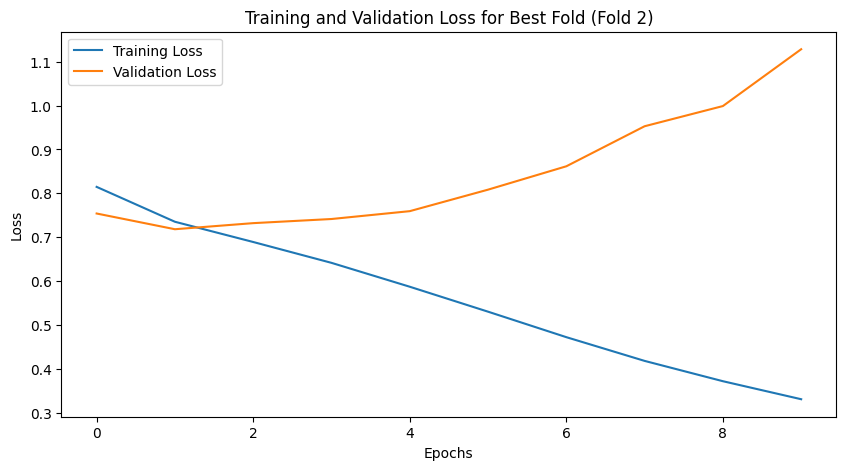

In [8]:
# Print the best fold details
print("\n--------------------------------------------------Best Fold Summary---------------------------------------------------------------------------")

best_fold_metrics = all_fold_metrics[best_fold_index]  # Retrieve the metrics of the best fold

# Print the metrics for the best fold
print(f"Best Fold: {best_fold_index + 1}")
print(f"Best Epoch: {best_fold_metrics['best_epoch']}")
print(f"Train Loss: {best_fold_metrics['train_loss']:.4f}")
print(f"Validation Loss: {best_fold_metrics['val_loss']:.4f}")
print(f"Accuracy: {best_fold_metrics['accuracy']:.4f}")
print(f"F Score: {best_fold_metrics['f_score']:.4f}")
print(f"Precision: {best_fold_metrics['precision']:.4f}")
print(f"Recall: {best_fold_metrics['recall']:.4f}")

# Retrieve the best fold's train and validation loss
best_fold_train_loss = all_fold_train_losses[best_fold_index]
best_fold_val_loss = all_fold_val_losses[best_fold_index]

# Plot the best fold's training and validation loss
plt.figure(figsize=(10, 5))
plt.title(f"Training and Validation Loss for Best Fold (Fold {best_fold_index + 1})")
plt.plot(best_fold_train_loss, label="Training Loss")
plt.plot(best_fold_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Model

In [9]:
print("\n--------------------------------------------------Test Set---------------------------------------------------------------------------")

# After all folds, use the best model (based on validation loss) to evaluate the test dataset
print("\nEvaluating on Test Dataset")

# Prepare the test dataset and dataloader
test_dataset = BanglaDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, num_workers=0)

# Load the best model's saved weights for the best fold (use the fold with best validation performance)
best_fold_model = LSTM_Model(embedding_dim=300, hidden_dim=64, num_classes=3, bidirectional=True)
best_fold_model.load_state_dict(torch.load(f"best_glove_bilstm_model_fold_{best_fold_index + 1}.pt"))
best_fold_model.to(DEVICE)

# Move to GPU and evaluate on the test dataset
best_fold_model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        (x, y) = batch
        out = best_fold_model(x)
        preds = torch.argmax(out, dim=1)
        test_predictions += preds.cpu().numpy().tolist()
        test_labels += y.cpu().numpy().tolist()


--------------------------------------------------Test Set---------------------------------------------------------------------------

Evaluating on Test Dataset
Loading GloVe Model
178153 words loaded!


C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\Rizvi\AppData\Local\Temp\ipykernel_10584\3958768321.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

Test Accuracy: 0.6958, F Score: 0.6786
nTest Precision: 0.6739, Test Recall: 0.6958

Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.74      0.73      2291
     Neutral       0.46      0.28      0.35      1445
    Positive       0.73      0.85      0.79      3224

    accuracy                           0.70      6960
   macro avg       0.64      0.62      0.62      6960
weighted avg       0.67      0.70      0.68      6960


Confusion Matrix:
[[1701  232  358]
 [ 406  408  631]
 [ 239  251 2734]]


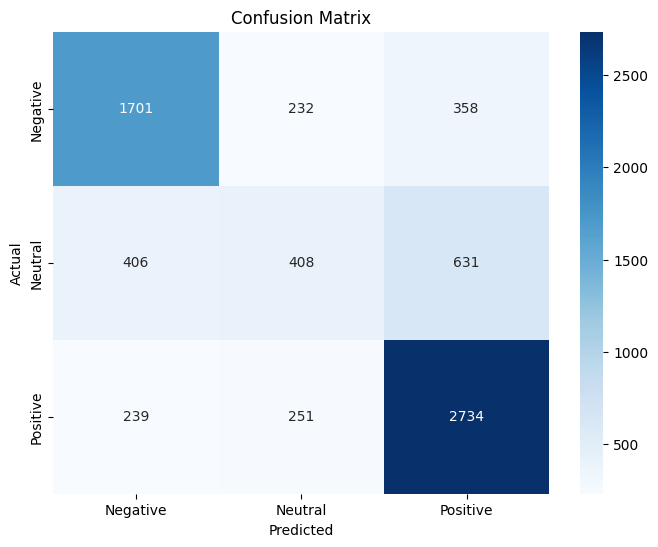

In [10]:
# Compute test metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_f_score = f1_score(test_labels, test_predictions, average="weighted")
test_precision = precision_score(test_labels, test_predictions, average="weighted")
test_recall = recall_score(test_labels, test_predictions, average="weighted")

# Display the final test metrics
print(f"Test Accuracy: {test_accuracy:.4f}, F Score: {test_f_score:.4f}")
print(f"nTest Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix:")
print(cm)

# Visualizing the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()